In [22]:
import warnings
warnings.simplefilter('ignore')

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 0.Setting

## 0.1.Import libraries

In [24]:
!pip install kmodes
!pip install --upgrade kmodes

Requirement already up-to-date: kmodes in /usr/local/lib/python3.6/dist-packages (0.10.2)


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from kmodes.kmodes import KModes

In [26]:
%cd '/content/drive/Shared drives/SI650/dataset/'

/content/drive/Shared drives/SI650/dataset


# 1.Clustering - KMode


## 1.1.Data preprocess

In [27]:
data_KMode = pd.read_csv("sephora_review_skincare_db_id.csv")

In [28]:
num_userid = data_KMode.user_id.value_counts()
num_userid.describe()

count    255242.000000
mean          1.618390
std           1.322122
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max          80.000000
Name: user_id, dtype: float64

In [29]:
main_users = []
for i in range(len(num_userid)):
    if num_userid.iloc[i] >= 5:
        main_users.append(num_userid.index[i])

In [30]:
df_sample = data_KMode[data_KMode.user_id.isin(main_users)]

In [31]:
df_user = df_sample[['user_id', 'product_id', 'rating', 
                     'skin_type', 'skin_tone', 'skin_concerns']].reset_index(drop=True)
df_user.skin_type.fillna('no answer', inplace = True)
df_user.skin_tone.fillna('no answer', inplace = True)
df_user.skin_concerns.fillna('no answer', inplace = True)

In [32]:
df_user.head()

,user_id,product_id,rating,skin_type,skin_tone,skin_concerns
0,87403,P461159,4,dry,light,blackheads
1,146950,P461159,3,combination,olive,aging
2,220930,P461159,5,dry,medium,aging
3,98917,P461159,5,combination,medium,acne
4,219497,P461159,4,dry,light,aging


In [33]:
df_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54169 entries, 0 to 54168
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   user_id        54169 non-null  int64 
 1   product_id     54169 non-null  object
 2   rating         54169 non-null  int64 
 3   skin_type      54169 non-null  object
 4   skin_tone      54169 non-null  object
 5   skin_concerns  54169 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.5+ MB


In [34]:
df_item = df_sample[['product_id', 'brand_id', 
                     'description', 'price']].reset_index(drop=True)

def pick_lowprice(price):
    idx = price.find('-')
    if idx == -1:
        return float(price[1:])
    else:
        return float(price[1:idx - 1])

def pick_highprice(price):
    idx = price.find('-')
    if idx == -1:
        return float(price[1:])
    else:
        return float(price[idx + 3:])

df_item['low_price'] = df_item.price.map(pick_lowprice)
df_item['high_price'] = df_item.price.map(pick_highprice)
df_item['rprice'] = 0.5 * (df_item.high_price + df_item.low_price)
df_item.drop(['price', 'low_price', 'high_price'], axis=1, inplace=True)

df_item['len_des'] = df_item.description.map(len)
df_item.drop_duplicates(['product_id','rprice'], inplace=True)
df_item.reset_index(drop=True, inplace=True)
df_item.drop(['len_des', 'description'], axis=1, inplace=True)

def map_price(price):
    if price <= 26.00:
        return 0
    elif price > 26.00 and price <= 40.00:
        return 1
    elif price >40.00 and price <= 60.875:
        return 2
    else:
        return 3

df_item['price_band'] = df_item.rprice.map(map_price)
df_item.drop('rprice', axis=1, inplace=True)
df_item.head()

df_user_item = df_user.merge(df_item, how='left', left_on='product_id', right_on='product_id')
df_user_item.head()

,user_id,product_id,rating,skin_type,skin_tone,skin_concerns,brand_id,price_band
0,87403,P461159,4,dry,light,blackheads,6089,3
1,146950,P461159,3,combination,olive,aging,6089,3
2,220930,P461159,5,dry,medium,aging,6089,3
3,98917,P461159,5,combination,medium,acne,6089,3
4,219497,P461159,4,dry,light,aging,6089,3


In [35]:
select_col = ['user_id', 'skin_type', 'skin_tone', 
              'skin_concerns', 'price_band', 'rating']

In [36]:
df_user_k = df_user_item.copy()
df_user_k = df_user_k[select_col]

df_user_ori = df_user_item.copy()
df_user_ori = df_user_ori[select_col]

In [37]:
convert = ['user_id', 'price_band', 'rating']
df_user_k[convert] = df_user_k[convert].astype('category')
df_user_ori[convert] = df_user_ori[convert].astype('category')

In [38]:
df_user_k.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54169 entries, 0 to 54168
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   user_id        54169 non-null  category
 1   skin_type      54169 non-null  object  
 2   skin_tone      54169 non-null  object  
 3   skin_concerns  54169 non-null  object  
 4   price_band     54169 non-null  category
 5   rating         54169 non-null  category
dtypes: category(3), object(3)
memory usage: 2.2+ MB


In [39]:
le = preprocessing.LabelEncoder()
df_user_k = df_user_k.apply(le.fit_transform)
df_user_k.head()

,user_id,skin_type,skin_tone,skin_concerns,price_band,rating
0,2620,1,4,2,3,3
1,4477,0,7,1,3,2
2,6831,1,5,1,3,4
3,2960,0,5,0,3,4
4,6777,1,4,1,3,3


#2.Run KModes

## 2.1.Initial Huang

In [40]:
# Choosing K by comparing Cost against each K
# https://www.kaggle.com/ashydv/bank-customer-clustering-k-modes-clustering
cost = []
for num_clusters in list(range(1,10)):
    kmode = KModes(n_clusters=num_clusters, init = "Huang", n_init = 1, verbose=1)
    kmode.fit_predict(df_user_k)
    cost.append(kmode.cost_)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 218966.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 7021, cost: 205218.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 6751, cost: 179793.0
Run 1, iteration: 2/100, moves: 19, cost: 179793.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 6167, cost: 174582.0
Run 1, iteration: 2/100, moves: 25, cost: 174582.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 8434, cost: 163466.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 17143, cost: 158742.0
Run 1, iteration: 2/100, moves: 2, cost: 158742.0
Init: initializing centroids
Init: initializing clus

## 2.2.Initial Cao

In [41]:
# Choosing K by comparing Cost against each K
# https://www.kaggle.com/ashydv/bank-customer-clustering-k-modes-clustering
# https://www.kaggle.com/teejmahal20/clustering-categorical-data-k-modes-cat-ii
cost2 = []
for num_clusters in list(range(1,10)):
    kmode = KModes(n_clusters=num_clusters, init = "Cao", n_init = 1, verbose=1)
    kmode.fit_predict(df_user_k)
    cost2.append(kmode.cost_)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 218966.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 12946, cost: 185521.0
Run 1, iteration: 2/100, moves: 316, cost: 185521.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 7152, cost: 174071.0
Run 1, iteration: 2/100, moves: 2, cost: 174071.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 6885, cost: 166040.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 8003, cost: 162796.0
Run 1, iteration: 2/100, moves: 1, cost: 162796.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 7697, cost: 157558.0
Run 1, iteration: 2/100, moves: 1, cost: 157558.0
In

Text(0, 0.5, 'cost')

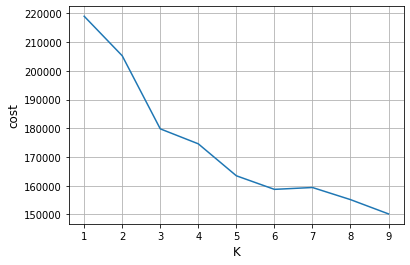

In [42]:
y = np.array([i for i in range(1,10,1)])
plt.plot(y,cost)
plt.grid(True)
plt.xlabel('K', size=12)
plt.ylabel('cost', size=12)

Text(0, 0.5, 'cost')

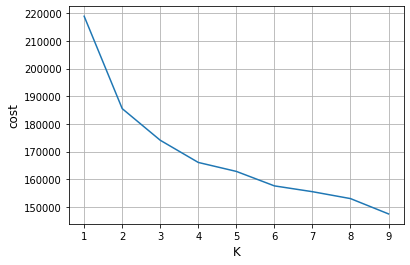

In [43]:
y = np.array([i for i in range(1,10,1)])
plt.plot(y,cost2)
plt.grid(True)
plt.xlabel('K', size=12)
plt.ylabel('cost', size=12)

## 2.3.Final model

In [44]:
# refit the model with selected K = 3
km_huang = KModes(n_clusters=3, init = "Huang", n_init = 1, verbose=1)
fitClusters_huang = km_huang.fit_predict(df_user_k)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 8921, cost: 177012.0
Run 1, iteration: 2/100, moves: 1, cost: 177012.0


In [45]:
# combine the cluster results back to the original dataframe
df_user_k2 = df_user_ori.reset_index()

clustersDf = pd.DataFrame(fitClusters_huang)
clustersDf.columns = ['cluster_predicted']
combinedDf = pd.concat([df_user_k2, clustersDf], axis = 1).reset_index()
combinedDf = combinedDf.drop(['index', 'level_0'], axis = 1)
combinedDf.head()

,user_id,skin_type,skin_tone,skin_concerns,price_band,rating,cluster_predicted
0,87403,dry,light,blackheads,3,4,1
1,146950,combination,olive,aging,3,3,0
2,220930,dry,medium,aging,3,5,0
3,98917,combination,medium,acne,3,5,0
4,219497,dry,light,aging,3,4,1


In [46]:
combinedDf.cluster_predicted.value_counts()

0    25899
2    15785
1    12485
Name: cluster_predicted, dtype: int64

In [47]:
# display some features
cluster_0 = combinedDf[combinedDf['cluster_predicted'] == 0]
cluster_1 = combinedDf[combinedDf['cluster_predicted'] == 1]
cluster_2 = combinedDf[combinedDf['cluster_predicted'] == 2]

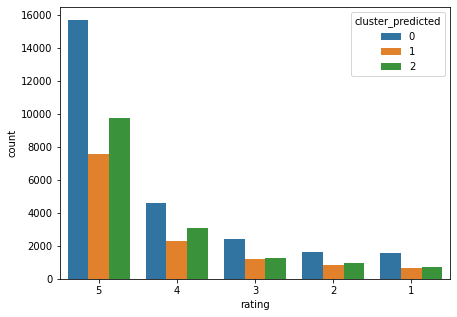

In [48]:
# rating
plt.subplots(figsize = (7,5))
sns.countplot(x=combinedDf['rating'], order=combinedDf['rating'].value_counts().index,
              hue=combinedDf['cluster_predicted'])
# plt.savefig('/content/drive/Shareddrives/SI650/Pictures/Cluster_rating3.png')
plt.show()

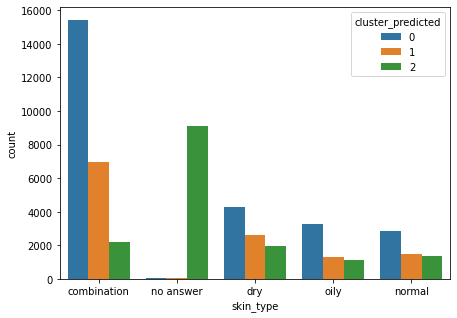

In [49]:
# skin types
plt.subplots(figsize = (7,5))
sns.countplot(x=combinedDf['skin_type'],order=combinedDf['skin_type'].value_counts().index,hue=combinedDf['cluster_predicted'])
plt.savefig('/content/drive/Shareddrives/SI650/Pictures/Cluster_Skin_type3.png')
plt.show()

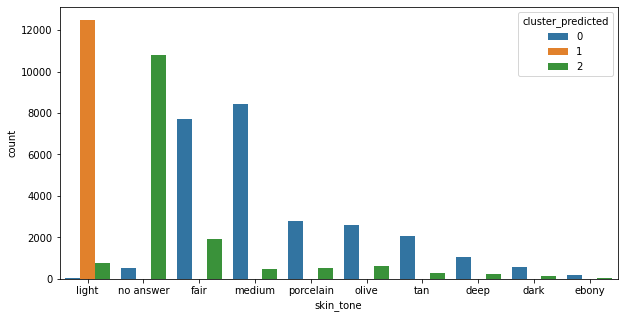

In [50]:
# skin tones
plt.subplots(figsize = (10,5))
sns.countplot(x=combinedDf['skin_tone'],order=combinedDf['skin_tone'].value_counts().index,hue=combinedDf['cluster_predicted'])
plt.savefig('/content/drive/Shareddrives/SI650/Pictures/Cluster_Skin_tone3.png')
plt.show()

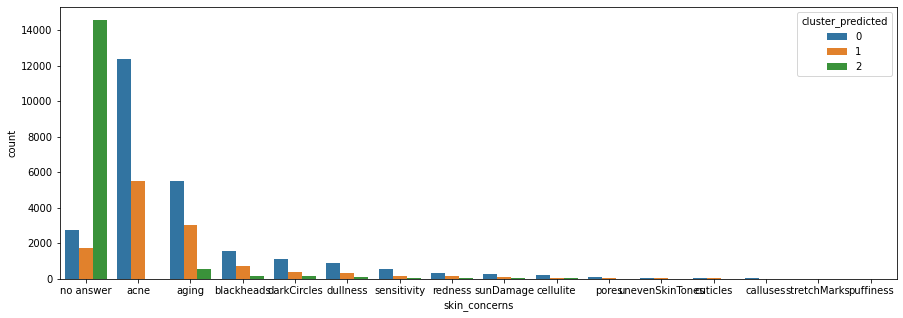

In [51]:
# skin concerns
plt.subplots(figsize = (15,5))
sns.countplot(x=combinedDf['skin_concerns'],order=combinedDf['skin_concerns'].value_counts().index, 
              hue=combinedDf['cluster_predicted'])
plt.savefig('/content/drive/Shareddrives/SI650/Pictures/Cluster_skin_concerns3.png')
plt.show()

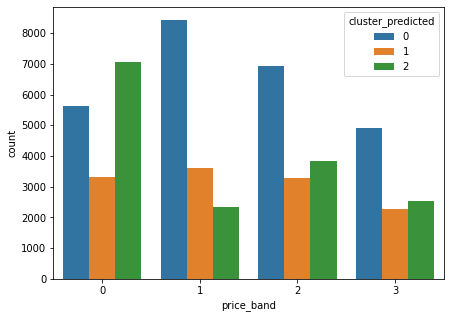

In [52]:
# price bands
plt.subplots(figsize = (7,5))
sns.countplot(x=combinedDf['price_band'],order=combinedDf['price_band'].value_counts().index,hue=combinedDf['cluster_predicted'])
plt.savefig('/content/drive/Shareddrives/SI650/Pictures/Cluster_Price_band3.png')
plt.show()

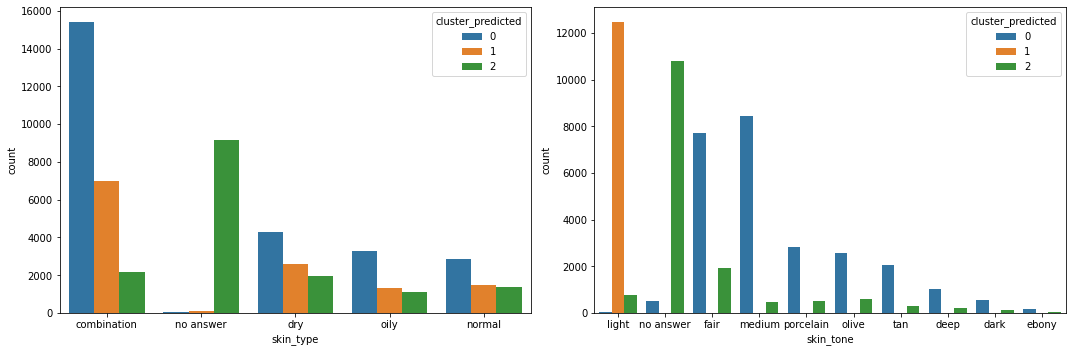

In [53]:
# skin types and skin tones
f, axs = plt.subplots(1,2,figsize = (15,5))
sns.countplot(x=combinedDf['skin_type'],order=combinedDf['skin_type'].value_counts().index,
              hue=combinedDf['cluster_predicted'],ax=axs[0])
sns.countplot(x=combinedDf['skin_tone'],order=combinedDf['skin_tone'].value_counts().index,
              hue=combinedDf['cluster_predicted'],ax=axs[1])

plt.tight_layout()
plt.show()

f.savefig('/content/drive/Shareddrives/SI650/Pictures/Cluster_skin_TypesAndTones3.png')

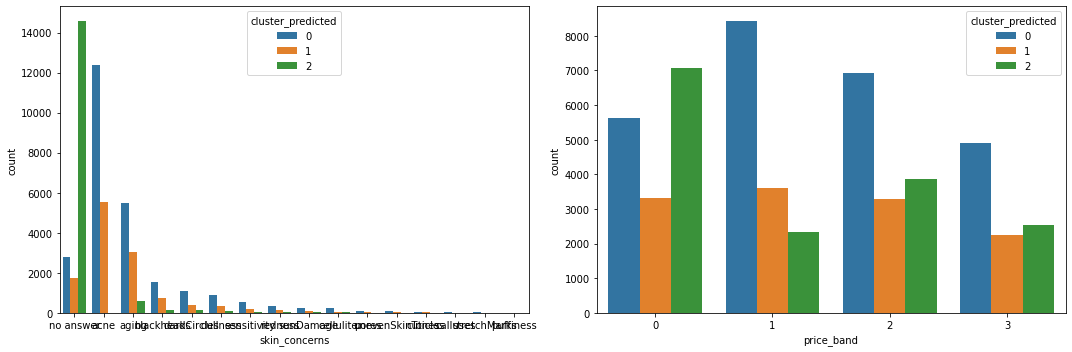

In [54]:
# skin concerns and price bands
f, axs = plt.subplots(1,2, figsize = (15,5))
sns.countplot(x=combinedDf['skin_concerns'], order=combinedDf['skin_concerns'].value_counts().index,
              hue=combinedDf['cluster_predicted'],ax=axs[0])
sns.countplot(x=combinedDf['price_band'], order=combinedDf['price_band'].value_counts().index,
              hue=combinedDf['cluster_predicted'],ax=axs[1])

plt.tight_layout()
plt.show()

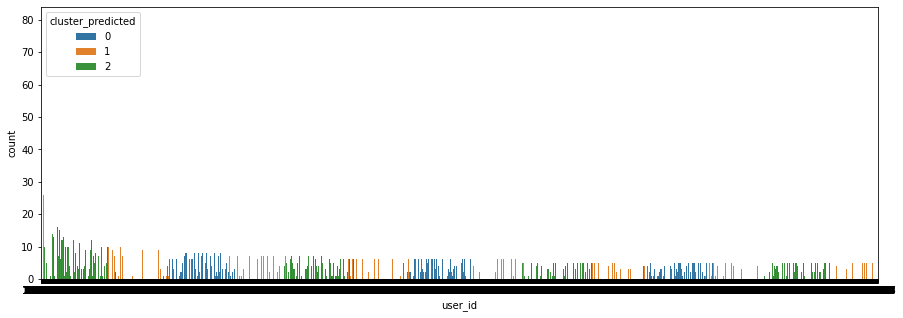

In [55]:
plt.subplots(figsize = (15,5))
sns.countplot(x=combinedDf['user_id'],order=combinedDf['user_id'].value_counts().index,hue=combinedDf['cluster_predicted'])
plt.show()

In [58]:
# An example of new user's information to find similar existing users
result = combinedDf[combinedDf.skin_type == 'combination']
result = result[result.skin_tone == 'medium']
result = result[result.skin_concerns == 'acne']
result = result[result.price_band == 3]
result = result[result.rating == 4]
result.cluster_predicted.value_counts()

0    93
Name: cluster_predicted, dtype: int64